<a href="https://colab.research.google.com/github/mohamed49/NTI-AI/blob/main/Titanic_classifiers.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Load dependencies

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn import linear_model
from sklearn.neighbors import KNeighborsClassifier
from sklearn import metrics
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay, classification_report

#Data Preprocessing

###Data reading

In [ ]:
df = pd.read_csv('Titanic-Dataset.csv')
df.describe(include='all')

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
count,891.000000,891.000000,891.000000,891,891,714.000000,891.000000,891.000000,891,891.000000,204,889
unique,NaN,NaN,NaN,891,2,NaN,NaN,NaN,681,NaN,147,3
top,NaN,NaN,NaN,"Dooley, Mr. Patrick",male,NaN,NaN,NaN,347082,NaN,G6,S
freq,NaN,NaN,NaN,1,577,NaN,NaN,NaN,7,NaN,4,644
mean,446.000000,0.383838,2.308642,NaN,NaN,29.699118,0.523008,0.381594,NaN,32.204208,NaN,NaN
std,257.353842,0.486592,0.836071,NaN,NaN,14.526497,1.102743,0.806057,NaN,49.693429,NaN,NaN
min,1.000000,0.000000,1.000000,NaN,NaN,0.420000,0.000000,0.000000,NaN,0.000000,NaN,NaN
25%,223.500000,0.000000,2.000000,NaN,NaN,20.125000,0.000000,0.000000,NaN,7.910400,NaN,NaN
50%,446.000000,0.000000,3.000000,NaN,NaN,28.000000,0.000000,0.000000,NaN,14.454200,NaN,NaN
75%,668.500000,1.000000,3.000000,NaN,NaN,38.000000,1.000000,0.000000,NaN,31.000000,NaN,NaN


###Data Cleaning

In [ ]:
df.drop_duplicates(inplace = True)

In [ ]:
imputer = SimpleImputer(strategy='mean')
df['Age'] = imputer.fit_transform(df[['Age']])


imputer = SimpleImputer(strategy='most_frequent')
df['Embarked'] = imputer.fit_transform(df[['Embarked']])[:,0]

df.isnull().sum()

,0
PassengerId,0
Survived,0
Pclass,0
Name,0
Sex,0
Age,0
SibSp,0
Parch,0
Ticket,0
Fare,0


###Data Transformation

In [ ]:
df['Age_Bin'] = pd.cut(df['Age'], bins=[0, 18, 30, 50, 80], labels=['Child', 'Young Adult', 'Adult', 'Senior'])
df['Fare_Bin'] = pd.qcut(df['Fare'], q=4, labels=['Low', 'Medium', 'High', 'Very High'])
df.drop(['Name','Ticket','Cabin','PassengerId'], axis=1, inplace=True)
df.head()

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,Age_Bin,Fare_Bin
0,0,3,male,22.0,1,0,7.2500,S,Young Adult,Low
1,1,1,female,38.0,1,0,71.2833,C,Adult,Very High
2,1,3,female,26.0,0,0,7.9250,S,Young Adult,Medium
3,1,1,female,35.0,1,0,53.1000,S,Adult,Very High
4,0,3,male,35.0,0,0,8.0500,S,Adult,Medium


In [ ]:
encoder = OneHotEncoder(sparse_output=False, handle_unknown='ignore') #sparse=False to return an array instead of a sparse matrix
one_hot_encoded = encoder.fit_transform(df[['Sex','Embarked','Age_Bin','Fare_Bin']])
one_hot_encoded_df = pd.DataFrame(one_hot_encoded, columns=encoder.get_feature_names_out(['Sex','Embarked','Age_Bin','Fare_Bin']))
df = pd.concat([df, one_hot_encoded_df], axis=1)
df.drop(['Sex','Embarked','Age','Fare','Age_Bin','Fare_Bin'], axis=1, inplace=True)
df.head()

,Survived,Pclass,SibSp,Parch,Sex_female,Sex_male,Embarked_C,Embarked_Q,Embarked_S,Age_Bin_Adult,Age_Bin_Child,Age_Bin_Senior,Age_Bin_Young Adult,Fare_Bin_High,Fare_Bin_Low,Fare_Bin_Medium,Fare_Bin_Very High
0,0,3,1,0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0
1,1,1,1,0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
2,1,3,0,0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
3,1,1,1,0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
4,0,3,0,0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0


In [ ]:
# scaler = StandardScaler()
# df[['Age','Fare']] = scaler.fit_transform(df[['Age','Fare']])


###correlation visualization

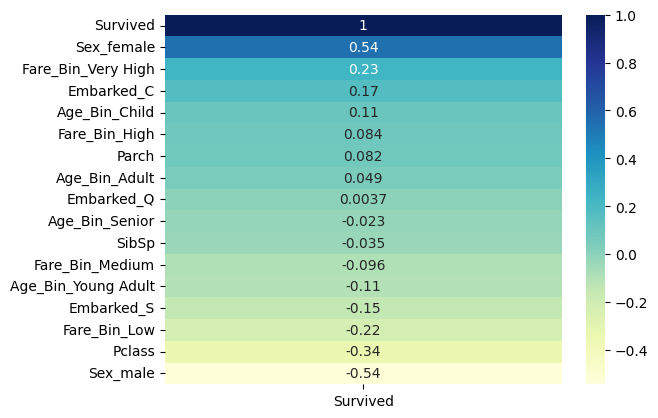

In [ ]:
corr=df.corr(numeric_only=True)
labeled_corr = corr[['Survived']].sort_values('Survived', ascending=False)
sns.heatmap(labeled_corr,annot=True,cmap="YlGnBu")
plt.show()

###Data Split

In [ ]:
# X = df.loc[:, ['Pclass','SibSp','Parch','Embarked_C','Embarked_Q','Embarked_S','Sex_female','Sex_male']]
# y = df.loc[:,['Survived']]

X = df.drop('Survived', axis=1)
y = df['Survived']


X_train, X_test,y_train, y_test = train_test_split(X,y,test_size=0.2,random_state=42)

X_train.shape

(668, 16)

#Multiclass logistic regression Model Training

In [ ]:
lm = linear_model.LogisticRegression(multi_class='ovr')
lm.fit(X_train, y_train)

/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:1256: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. Use OneVsRestClassifier(LogisticRegression(..)) instead. Leave it to its default value to avoid this warning.
  warnings.warn(


LogisticRegression(multi_class='ovr')

#KNN Model Training

In [ ]:
knn = KNeighborsClassifier(n_neighbors=5)
knn.fit(X_train, y_train)

KNeighborsClassifier()

#Naive Bayes Model Training

#SVM Model Training

#Model Testing

In [ ]:
# Predict on the Test Data
y_pred_lr = lm.predict(X_test)
y_pred_knn = knn.predict(X_test)

###Logistic regression model scores

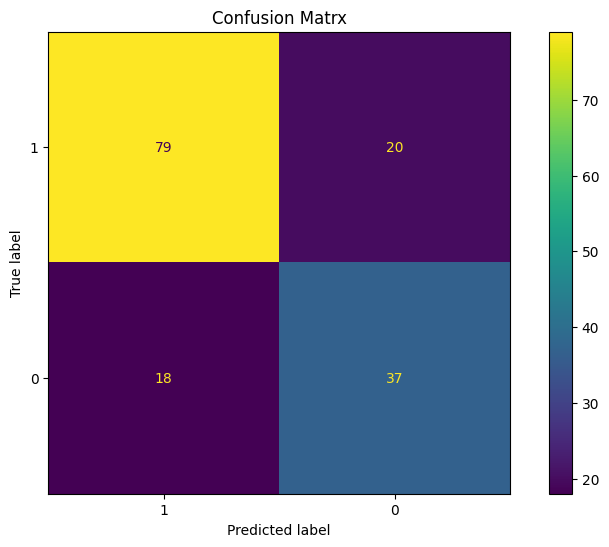

In [ ]:
#Creating matplotlib axes object to assign figuresize and figure title
fig, ax = plt.subplots(figsize=(10, 6))
ax.set_title('Confusion Matrx')

#Generate the confusion matrix
cm = confusion_matrix(y_test, y_pred_lr)

#plot the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=df['Outcome'].unique())
disp.plot(ax=ax)

plt.show()

In [ ]:
#Calculating Scoring Matrices
print(metrics.classification_report(y_test, lm.predict(X_test)))

              precision    recall  f1-score   support

           0       0.81      0.80      0.81        99
           1       0.65      0.67      0.66        55

    accuracy                           0.75       154
   macro avg       0.73      0.74      0.73       154
weighted avg       0.76      0.75      0.75       154



###KNN model scores

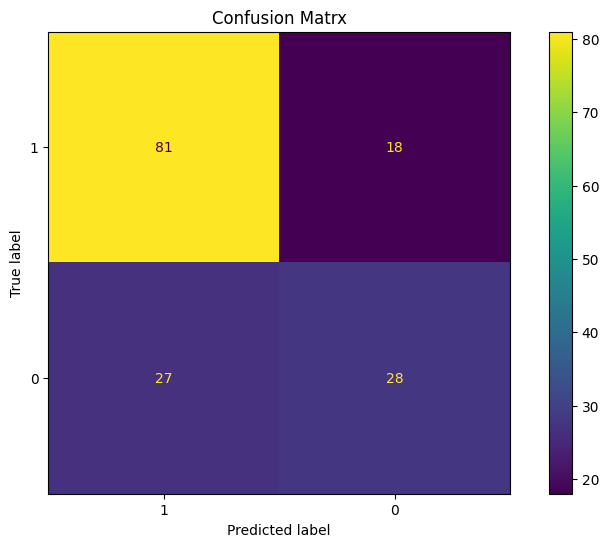

In [ ]:
#Creating matplotlib axes object to assign figuresize and figure title
fig, ax = plt.subplots(figsize=(10, 6))
ax.set_title('Confusion Matrx')

#Generate the confusion matrix
cm = confusion_matrix(y_test, y_pred_knn)

#plot the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=df['Outcome'].unique())
disp.plot(ax=ax)

plt.show()

In [ ]:
#Calculating Scoring Matrices
print(metrics.classification_report(y_test, y_pred_knn))

              precision    recall  f1-score   support

           0       0.75      0.82      0.78        99
           1       0.61      0.51      0.55        55

    accuracy                           0.71       154
   macro avg       0.68      0.66      0.67       154
weighted avg       0.70      0.71      0.70       154

